In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

In [3]:
cali = fetch_california_housing()
cali_df = pd.DataFrame(cali['data'], columns=cali['feature_names'])
cali_df['Target'] = cali['target']
cali_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [12]:
data = torch.from_numpy(cali_df.values).float()
X = data[:, :-1]
y = data[:, -1:]
X.shape, y.shape

(torch.Size([20640, 8]), torch.Size([20640, 1]))

In [13]:
ratios = [0.6, 0.2, 0.2]
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]
cnts

[12384, 4128, 4128]

In [14]:
indices = torch.randperm(data.size(0))
x = torch.index_select(X, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)
x = list(x.split(cnts, dim=0))
y = y.split(cnts, dim=0)

In [15]:
for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


In [19]:
scaler = StandardScaler().fit(x[0].numpy())
x[0] = torch.from_numpy(scaler.transform(x[0].numpy())).float()
x[1] = torch.from_numpy(scaler.transform(x[1].numpy())).float()
x[2] = torch.from_numpy(scaler.transform(x[2].numpy())).float()

In [20]:
model = nn.Sequential(
    nn.Linear(x[0].shape[-1], 5),
    nn.LeakyReLU(0.01),
    nn.Linear(5, 3),
    nn.LeakyReLU(0.01),
    nn.Linear(3, y[0].shape[-1])
)
print(model)

Sequential(
  (0): Linear(in_features=8, out_features=5, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=5, out_features=3, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=3, out_features=1, bias=True)
)


In [21]:
opt = optim.Adam(model.parameters())

In [22]:
n_epochs = 2000
batch_size = 256
print_interval = 200

In [23]:
lowest_loss = np.inf
best_model = None
early_stop = 100
lowest_epoch = np.inf

In [24]:
train_history, valid_history = [], []

In [25]:
for i in range(n_epochs):
    indices = torch.randperm(x[0].size(0))
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += float(loss)
    
    train_loss = train_loss / len(x_)

    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.mse_loss(y_hat_i, y_i)

            valid_loss += float(loss)
            y_hat += [y_hat_i]
        
        valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]

    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print(f'There is no improvement during last {early_stop} epochs.')
            break

    if (i+1) % print_interval == 0:
        print(f'Epoch {i+1}: Train loss:{train_loss:.4f}, Valid loss:{valid_loss:.4f}, Lowest loss:{lowest_loss:.4f}')

print(f'The best valid loss from epoch {lowest_epoch+1}: {lowest_loss:.4f}')

Epoch 200: Train loss:0.3429, Valid loss:0.3638, Lowest loss:0.3638
Epoch 400: Train loss:0.3353, Valid loss:0.3591, Lowest loss:0.3564
There is no improvement during last 100 epochs.
The best valid loss from epoch 447: 0.3551


In [26]:
model.load_state_dict(best_model)

<All keys matched successfully>

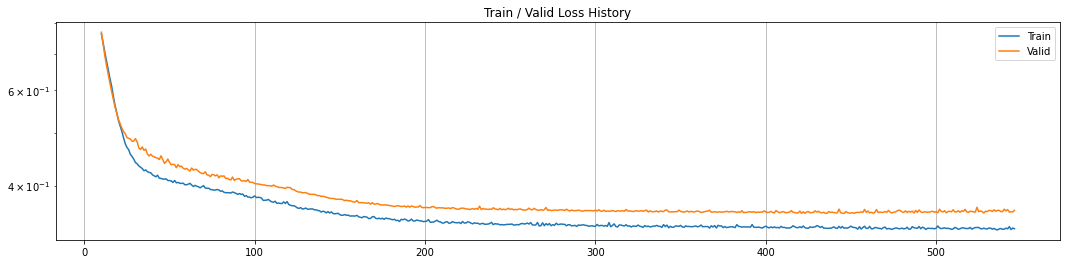

In [27]:
plot_from = 10

fig, ax = plt.subplots(1, 1, figsize=(18, 4))
plt.title('Train / Valid Loss History')
ax.plot(range(plot_from, len(train_history)), train_history[plot_from:],
         range(plot_from, len(valid_history)), valid_history[plot_from:])
plt.grid(True)
plt.yscale('log')
plt.legend(['Train', 'Valid'])
plt.show()

In [28]:
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    test_loss = 0

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        test_loss += float(loss)
        y_hat += [y_hat_i]
    
    test_loss = test_loss / len(x_)

y_hat = torch.concat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])

In [32]:
print(f'Train loss: {sorted_history[0][0]:.4f}')
print(f'Valid loss: {sorted_history[0][1]:.4f}')
print(f'Test loss: {test_loss:.4f}')

Train loss: 0.3334
Valid loss: 0.3551
Test loss: 0.3402
